In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


The VBAC model does not have a specific dataset that i could be using, generating a synthetic dataset based on reasonable assumptions is what i can do. 

In [98]:
np.random.seed(100)

num_samples = 5000

data = {
    'age': np.random.normal(35, 5, num_samples),
    'BMI': np.random.normal(25, 4, num_samples),
    'AA': np.random.choice([0, 1], num_samples, p=[0.85, 0.15]),
    'Hispanic': np.random.choice([0, 1], num_samples, p=[0.80, 0.20]),
    'vaginal_delivery_before_ceasarean': np.random.choice([0, 1], num_samples, p=[0.7, 0.3]),
    'vaginal_delivery_after_ceasarean': np.random.choice([0, 1], num_samples, p=[0.95, 0.05]),
    'recurrent_indication_for_ceasarean': np.random.choice([0, 1], num_samples, p=[0.6, 0.4]),
    'estimated_gestational_age': np.random.normal(39, 1, num_samples),
    'hypertensive_disease': np.random.choice([0, 1], num_samples, p=[0.9, 0.1]),
    'effacement': np.random.uniform(0, 100, num_samples),
    'dilatation': np.random.uniform(0, 10, num_samples),
    'station': np.random.randint(-5, 6, num_samples), # Discrete integer values
    'induction_of_labor': np.random.choice([0, 1], num_samples, p=[0.75, 0.25]),
}

X = pd.DataFrame(data)

# filter out dual races
X.loc[(X['AA'] == 1) & (X['Hispanic'] == 1), 'Hispanic'] = 0

# clean up data
X['age'] = X['age'].apply(lambda x: max(25, x))
X['BMI'] = X['BMI'].apply(lambda x: max(18, x))
X['estimated_gestational_age'] = X['estimated_gestational_age'].apply(lambda x: max(30, x))

def model(row):
    w = (7.059 - 0.037 * row['age'] - 0.44 * row['BMI'] -
         0.46 * row['AA'] - 0.761 * row['Hispanic'] +
         0.955 * row['vaginal_delivery_before_ceasarean'] +
         0.851 * row['vaginal_delivery_after_ceasarean'] -
         0.655 * row['recurrent_indication_for_ceasarean'] -
         0.109 * row['estimated_gestational_age'] -
         0.499 * row['hypertensive_disease'] +
         0.044 * row['effacement'] + 0.109 * row['dilatation'] +
         0.082 * row['station'] - 0.452 * row['induction_of_labor'])
    return 1 / (1 + np.exp(-w))

X["pred"] = X.apply(model, axis=1)

In [99]:
X_AA = X[X["AA"] == 1]
X_Hispanic = X[X["Hispanic"] == 1]

counterfactual_X_AA = X_AA.copy()
counterfactual_X_AA["AA"] = 0
counterfactual_X_AA['counterfactual_AA'] = model(counterfactual_X_AA)

counterfactual_X_Hispanic = X_Hispanic.copy()
counterfactual_X_Hispanic["Hispanic"] = 0
counterfactual_X_Hispanic['counterfactual_Hispanic'] = model(counterfactual_X_Hispanic)

X

,age,BMI,AA,Hispanic,vaginal_delivery_before_ceasarean,vaginal_delivery_after_ceasarean,recurrent_indication_for_ceasarean,estimated_gestational_age,hypertensive_disease,effacement,dilatation,station,induction_of_labor,pred
0,26.251173,19.214736,1,0,0,1,0,39.070024,0,53.159977,6.762101,-1,0,0.037677
1,36.713402,20.420412,0,0,0,0,0,39.190195,0,81.648750,6.032244,3,0,0.044786
2,40.765179,32.626386,0,1,0,0,1,37.350484,0,37.067478,0.545773,1,0,0.000004
3,33.737820,23.025942,0,1,0,0,1,38.147029,0,79.621255,3.849389,0,0,0.002543
4,39.906604,18.000000,0,0,1,0,0,39.365450,0,85.418324,7.794894,-4,1,0.136422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,34.702925,31.605744,0,0,0,0,1,39.932529,0,69.473274,0.270970,-2,1,0.000023
4996,40.602508,25.413120,0,0,0,0,0,38.613054,0,16.194503,0.524478,1,0,0.000126
4997,35.317312,23.203995,0,0,1,0,1,39.457738,0,87.790474,6.958050,-5,0,0.014103
4998,28.343979,27.930908,0,0,1,0,0,40.467566,0,48.649178,2.066145,-2,0,0.000535


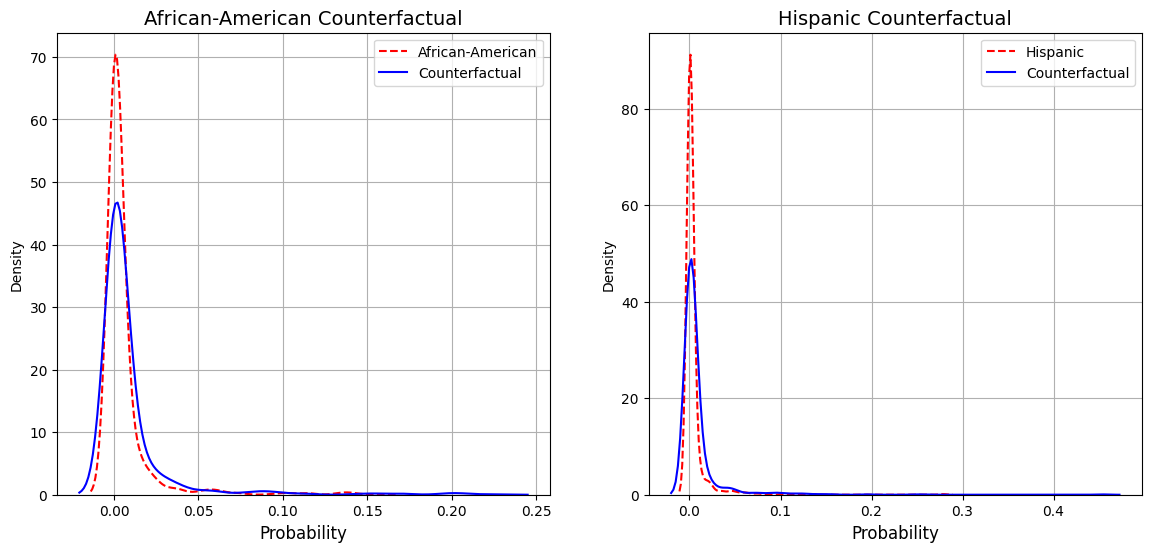

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(X_AA['pred'], label='African-American', color='red', linestyle='--', ax=axes[0])
sns.kdeplot(counterfactual_X_AA['counterfactual_AA'], label='Counterfactual', color='blue', ax=axes[0])
axes[0].set_title('African-American Counterfactual', fontsize=14)
axes[0].set_xlabel('Probability', fontsize=12)
axes[0].legend()
axes[0].grid(True)

sns.kdeplot(X_Hispanic['pred'], label='Hispanic', color='red', linestyle='--', ax=axes[1])
sns.kdeplot(counterfactual_X_Hispanic['counterfactual_Hispanic'], label='Counterfactual', color='blue', ax=axes[1])
axes[1].set_title('Hispanic Counterfactual', fontsize=14)
axes[1].set_xlabel('Probability', fontsize=12)
axes[1].legend()
axes[1].grid(True)


plt.show()